In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Fetch LFW dataset with minimum faces per person = 40
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.4)
# Extracting data and target labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
# df = np.genfromtxt('./lfw_people.csv',delimiter=',')
# X = df[:, :-1]
# y = df[:, -1]
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

# Print dataset statistics
print("Number of samples: %d" % n_samples)
print("Number of features: %d" % n_features)
print("Number of classes: %d" % n_classes)

Number of samples: 1867
Number of features: 1850
Number of classes: 19


## Building a PCA class

In [3]:
class PCA:
  def __init__(self,n_components=None):
    # To initialize a PCA object

    # Total number of reduced features in projected data
    self.n_components = n_components
    self.eigenvalues = None
    self.eigenvectors=None
    self.means=None

  def fit(self,X):
    # To fit the model and finding principal components given an array X.
    if self.n_components==None:
      self.n_components=X.shape[0]
    self.means = np.mean(X,axis=0)
    X_mean = X-self.means
    cov_matrix = (X_mean.T @ X_mean)/X_mean.shape[0]
    cov_matrix = (cov_matrix + cov_matrix.T)/2
    self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)
    self.eigenvalues = np.abs(np.real(self.eigenvalues))
    self.eigenvectors = np.real(self.eigenvectors)

    # (v) Sort eigenvectors based on eigenvalues
    # print(eigenvalues[eigenvalues<0])
    sorted_indices = np.argsort(self.eigenvalues)[::-1]
    self.eigenvalues = self.eigenvalues[sorted_indices]
    self.eigenvectors = self.eigenvectors[:, sorted_indices]
    self.eigenvectors = self.eigenvectors/np.sqrt((np.sum(self.eigenvectors*self.eigenvectors, axis=0)))
    return X @ self.eigenvectors[:,:self.n_components]

  def fit_transform(self,X):
    # returns the given array after projected it along principal components
    return X @ self.eigenvectors[:,:self.n_components]


  def explained_variance(self):
    # returns first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]
  def explained_variance_ratio(self):
    # returns ratio of variance captured by first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]/np.sum(self.eigenvalues)

  def components(self):
    # returns principal components
    return self.eigenvectors[:,:self.n_components]

  def get_eigenvalues(self):
    # returns all eigen values
    return self.eigenvalues
  def get_eigenvectors(self):
    # returns all eigenvectors
    return self.eigenvectors

### PCA implementation

In [4]:
# To perform splitting of data into train and test sets with ratio 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
num_components=192   # To reduce the data into 200 features.
# To apply PCA on train data and get principal components.
pca = PCA(n_components=num_components)
X_projected = pca.fit(X_train)
X_test_projected = pca.fit_transform(X_test)
principal_components = pca.components()
# Convert principal components back to eigen faces.
eigenfaces = (principal_components.T).reshape((principal_components.shape[1],50,37))

# Reconstruct the original data from the extracted features.
X_reconstructed = (X_projected @ (principal_components.T))

### Explained Variance ratio

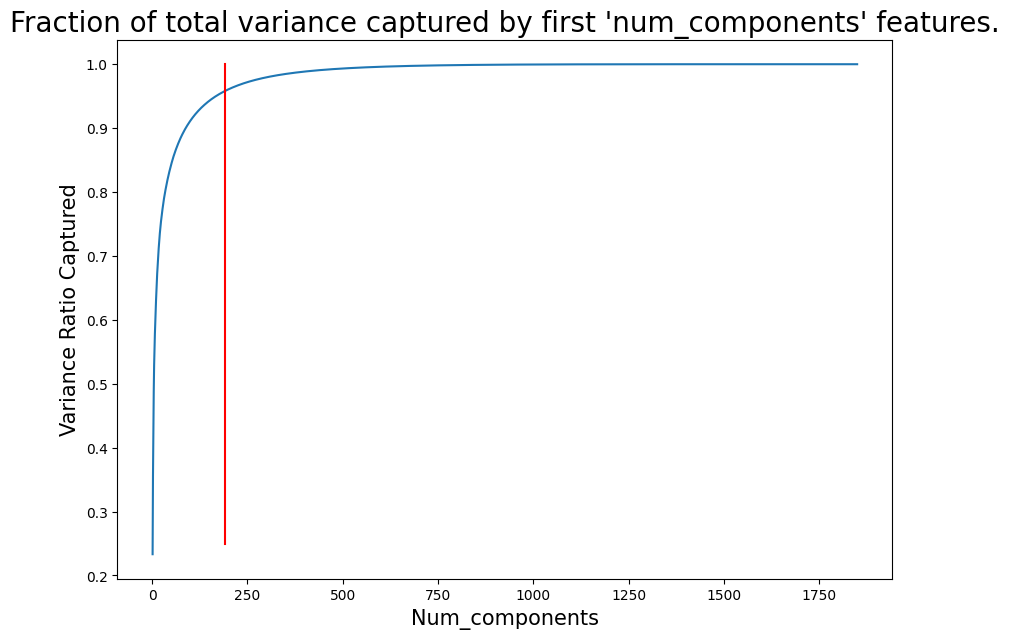

In [5]:
# To plot the graph of total variance captured by first 'num_components' eigen vectors.
x = np.arange(1,1851,1)
y = np.cumsum(pca.get_eigenvalues())/np.sum(pca.get_eigenvalues())
plt.figure(figsize=(10,7))
plt.plot(x,y)

x = [num_components,num_components]
y = [0.25,1]
plt.plot(x,y,'r')
plt.title("Fraction of total variance captured by first 'num_components' features.",size=20)
plt.xlabel("Num_components",size=15)
plt.ylabel("Variance Ratio Captured",size=15)
plt.show()

### Eigen Faces

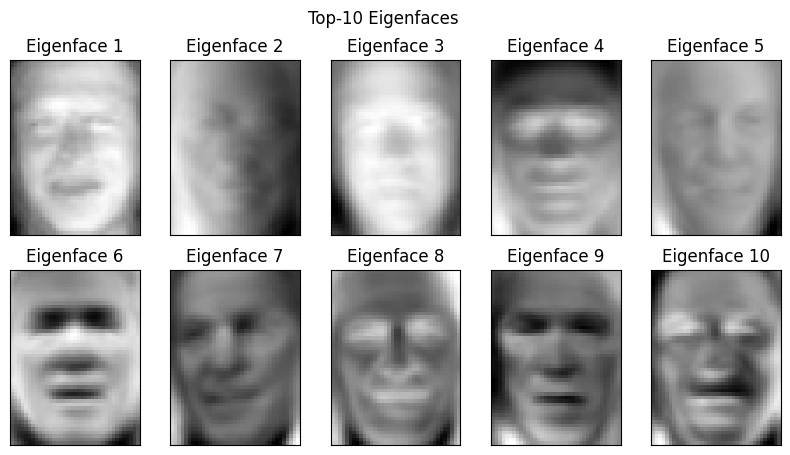

In [6]:
# To plot the first 10 eigenfaces
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.title(f"Eigenface {i + 1}")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Top-10 Eigenfaces")
plt.show()

### Reconstructed face data

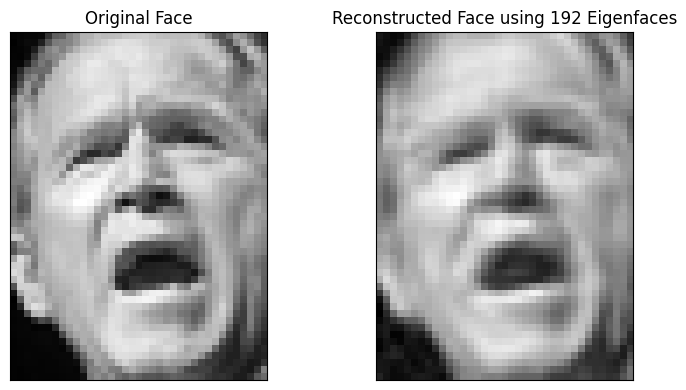

In [7]:
og_face0 = X_train[0].reshape((50,37))
reconstructed_face0 = X_reconstructed[0].reshape((50,37))
# Plot the original and reconstructed faces
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(og_face0, cmap='gray')  # Reshape to original shape before plotting
plt.title('Original Face')
plt.xticks(())
plt.yticks(())

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_face0, cmap='gray')
plt.title(f'Reconstructed Face using {num_components} Eigenfaces')
plt.xticks(())
plt.yticks(())

plt.tight_layout()
plt.show()

In [8]:
class LDAclass:
    def __init__(self, n_components):
        self.n_components = n_components
    def fit_transform(self,X_train,Y_train):
        #X_train = X_train.T
        overall_mean = np.mean(X_train, axis=0)

        Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
        Sb = np.zeros((X_train.shape[1], X_train.shape[1]))
        for i in np.unique(Y_train):
            class_indices = np.where(Y_train == i)[0]
            class_data = X_train[class_indices,:]
            class_mean = np.mean(class_data, axis=0)
            class_mean_diff = class_data - class_mean
            Sw += class_mean_diff.T @ class_mean_diff

        overall_mean_diff = X_train-overall_mean
        Sb = overall_mean_diff.T @ overall_mean_diff
        Sb-=Sw

        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw) @ Sb)
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)
        eigenvectors = eigenvectors/np.sqrt(np.sum(eigenvectors*eigenvectors))
        #eigenvectors = eigenvectors/(np.sum(eigenvectors*eigenvectors,axis=0))

        sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
# Only the first 6 eigenvalues have significance. Remaining values are close to zero compared to first six eigenvalues.

        self.principal_components = eigenvectors[:, :self.n_components]
        X_projected = X_train @ self.principal_components
        print(eigenvalues[:10])
        return X_projected

    def transform(self,X):
        return X @ self.principal_components

    def fischerfaces(self):
        return ((self.principal_components.T).reshape((self.principal_components.shape[1],16,12)))

[3.07188397 2.08018643 1.508612   1.34851006 1.20803248 0.96108575
 0.85975836 0.78633725 0.65384732 0.56885724]


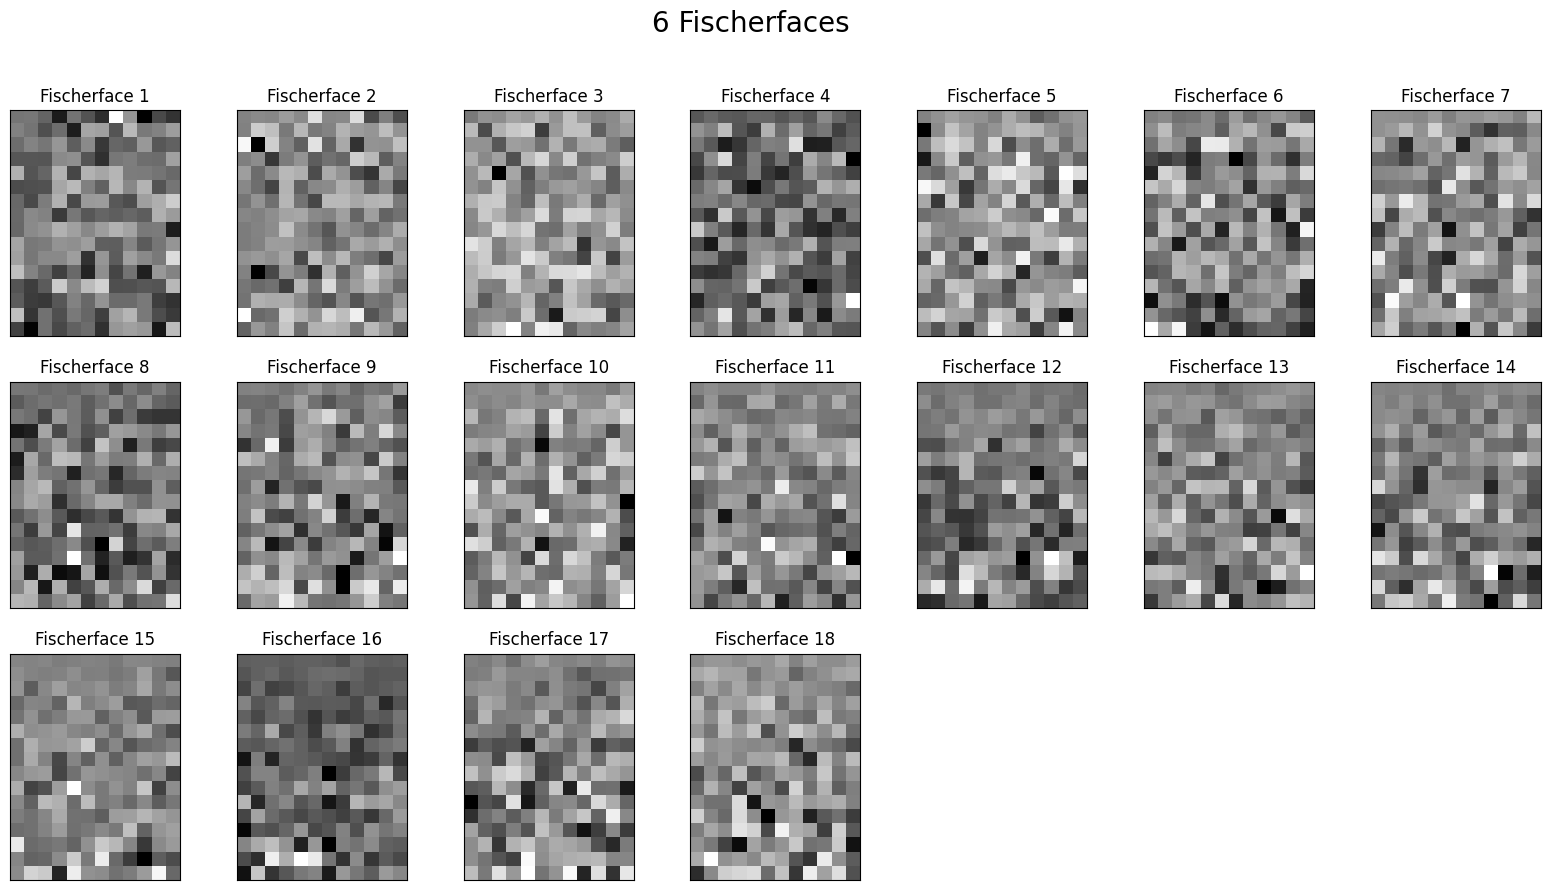

In [9]:
X_projected = X_train @ principal_components
X_test_projected = X_test @ principal_components
n_components=len(np.unique(Y_train)) - 1
lda = LDAclass(n_components = n_components)
X_projected = lda.fit_transform(X_projected, Y_train)
X_test_projected = lda.transform(X_test_projected)
fischerfaces = lda.fischerfaces()
plt.figure(figsize=(20,10))
for i in range(n_components):
    plt.subplot(3,7 , i + 1)
    plt.imshow(fischerfaces[i], cmap='gray')
    plt.title(f"Fischerface {i + 1}")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("6 Fischerfaces",size = 20)
plt.show()

# ANN

In [10]:
X_train = X_projected
X_test = X_test_projected
y_train = Y_train
y_test = Y_test

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network architecture
class ANN(nn.Module):
    def __init__(self, input_features, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_features, 3*num_classes)
        # self.fc2 = nn.Linear(2*num_classes,2*num_classes)
        self.fc3 = nn.Linear(3*num_classes, num_classes)  # Single output neuron for multiclass classification
        # self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)  # Apply softmax to output

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        # x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        # x = self.softmax(x)
        return x


# Training Model Function
def train_model(model, optimizer,  train_loader, criterion, num_epochs=100):
  # Set model to train mode
  model.train()

  #training loop
  for epoch in range(num_epochs):
      print(epoch, end=" ")
      for inputs, targets in train_loader:
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

# Testing Model Function
def test_model(model , test_loader):
  # Evaluation
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, targets in test_loader:
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          correct = (predicted == targets).sum().item()
          total = targets.size(0)

  test_accuracy = correct / total
  print(f"\nTest Accuracy: {test_accuracy:.4f}")
  return predicted

In [65]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0])

# Instantiate the model
input_features = X_train.shape[1]  # Number of features
num_classes = len(torch.unique(y_train_tensor))  # Number of classes
model = ANN(input_features, num_classes)

# Define loss function and optimizer
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for multiclass classification
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Example learning rate and momentum values

In [66]:
train_model(model,optimizer,train_loader,criterion,150)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 


Test Accuracy: 0.7487


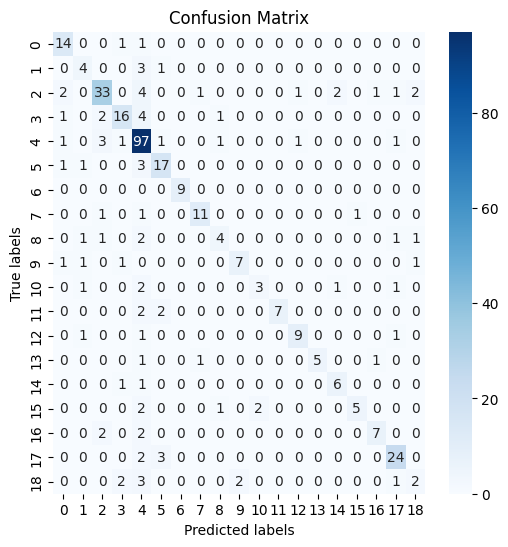

In [67]:
y_pred = test_model(model, test_loader)

## Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
state_dict = model.state_dict()
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = ANN(input_features, num_classes)
new_model.load_state_dict(state_dict)

<All keys matched successfully>